>This post is about the Dynamical Variational Autoencoder, which is like the Variational Autoencoder but for sequences of inputs such as time series. It is meant to be the sequel to my post about Variational Autoencoders

## Introduction
Previously I have gone over Variational Autoencoders and mentioned that they are not suitable in their common form if we want to learn the underlying latent dynamics of a system. The main problem is that the generative model (the prior and decoder) only generates static data and isn't concerned with the underlying dynamics of the data. For example, if we want to use the VAE to generate a sequence of positions of a moving object $X = [x_1,...,x_T]$ then we would do the following,

* Sample from the prior, $Z = [z_1,...,z_T] \sim p(Z)$
* Decode the samples, $p_{\theta_x}(X|Z)$ and sample generated input data $X$

Note, when I refer to the generative model I refer to the joint distribution between the input variables ($X$) and the latent variables ($Z$) i.e. $p(X,Z)$. This can be written as $p(X,Z) = p(X|Z)p(Z)$ which is just the decoder and prior of a VAE. Hence, when I refer to the generative model I am referring to these two components of the VAE which can practically be applied using the above steps.

Here the generative model essentially defines all possible input position sequences $X=[x_1,...,x_T]$. But what if we want to generate any arbitrary length e.g. we have some data and want to forecast possible future positions until they reach some target position. Or what if I want to understand or use the underlying dynamics behind these positions, so I can generate more accurate or plausible sequences. How would I do this? 

Luckily there are a type of VAE called the Dynamical Variational Autoencoder (DVAE) which solves this problem and improves the quality of generated sequential signals when compared to the regular VAE. The same underlying theory from the VAE is still there, in fact the underlying model is pretty much the same we just need to write it in a different mathematical form and we will get the DVAE. I'll try to go through a lot of the basic theory in this post, but if you want a more in-depth resource on DVAEs, then I highly suggest the following review paper [@Girin2020]. 

## Theory

So how do we implement a DVAE? Well lets first look at the components of a regular VAE, 

* Inference model: $q_{\phi}(Z|X)$
* Generative model: $p_{\theta}(X,Z) = p_{\theta_x}(X|Z) p_{\theta_z}(Z)$ 

Where any subscripts on these probability distributions are the learnable parameters of the neural network that represents the distribution e.g. if $q_{\phi}(Z|X)$ is the neural network with inputs $X$ and outputs $Z$ then $\phi$ are the learnable parameters that will be optimised during training. 

Note, if you are familiar with VAEs you may wonder why the prior $p_{\theta_z}(Z)$ has parameters $\theta_z$ associated with it, as we normally define it as a standard normal distribution (so there is nothing to optimise). This is because in the DVAE formulation it will be a neural network, so it's a teaser for later (you can ignore it for now).

Now all we need to do is say that these variables are sequences of some arbitrary length $T$ i.e. $X= x_{1:T} = [x_1,...,x_T]$ and $Z = z_{1:T} =[z_1,...,z_T]$ and substitute this in. 

* Inference model: $q_{\phi}(z_{1:T}|x_{1:T})$
* Generative model: $p_{\theta}(x_{1:T},z_{1:T}) = p_{\theta_x}(x_{1:T}|z_{1:T}) p_{\theta_z}(z_{1:T})$ 

Okay, you might be thinking "how has this helped", well we can now rewrite these probability distributions as products of other probability distributions. Let's first illustrate this for the generative model.

$$
    \text{Generative: } p_{\theta}(x_{1:T}, z_{1:T}) = \prod_{t=1}^T p_{\theta_x}(x_t|x_{1:t-1}, z_{1:t}) p_{\theta_z}(z_t|z_{1:t-1}, x_{1:t-1})
$$

Notice now we have this causal model, which is to say variables at time $t$ only depend on past variables $1:t-1$ (the present value is determined by the past values). This means our new decoder and prior models become, 

$$
    \text{Decoder: } p_{\theta_x}(x_t|x_{1:t-1}, z_{1:t}) \\
    \text{Prior: } p_{\theta_z}(z_t|z_{1:t-1}, x_{1:t-1})
$$

The prior generates the next latent variable $z_t$ which can then be used to input all $z_{1:t}$ into the decoder. We can alternate or chain this operation to generate an entire sequence of $x_{1:T}$ for any arbitrary value of $T$ by simply alternating between generating the next $z_t$ value and then generate $x_t$, which helps generate $z_{t+1}$ which generates $x_{t+1}$ and so on. 

But to train the generative model we need an inference model to encode the inputs to a latent space. When breaking the inference model into a product of distributions we get, 

$$
    \text{Inference: } q_{\phi}(z_{1:T}|x_{1:T}) = \prod_{t=1}^T q_{\phi}(z_t|z_{1:t-1}, x_{1:T}) 
$$

This cannot be simplified further; unlike the joint distribution we are stuck with the fact we are given $x_{1:T}$. Hence, this is a noncausal model where future values are needed to calculate present variables at time $t$. Since the inference model is only used when training, $x_{1:T}$ is anyway a given/available to us. This is because it is our training data, so it's not a big deal that this model is noncausal (we are not cheating by looking into the future). But this does have an important impact on the model which may not be intuitive. As my gut instinct if I had to extend the VAE for sequential inputs would be to use $x_{1:t}$ for the inference model. However, by breaking the probability distribution of the sequence into the product of distributions which represent the current values at time $t$ we can see $x_{1:T}$ is needed for the inference model. But how do we represent entire sequences (which could be any arbitrary length $T$) so that they can be used as inputs to a neural network?

The most common way is to use a Recurrent Neural Network (RNN). Many implementations will input a sequence (e.g. $x_{1:t}$) and let the hidden variable at that time $t$ be a representation of the entire sequence i.e. $h_t := x_{1:t}$. This can be seen in the diagram below where the RNN cell takes in the previous hidden state ($h_{t-1}$) and current input value ($x_t$) and outputs $h_t$. Since each hidden state carries the information of the previous and current input, $x_{1:t}$, the hidden state $h_t$ is used to represent this input sequence. Note theoretically other models could be used to represent the input sequence $x_{1:t}$, but the RNN is chosen due to its simplicity as it represents the entire sequence with just one variable $h_t$. For $x_{1:T}$ we can use a forward-backward RNN, where we essentially run the forward RNN (as shown in the diagram) and then run another backwards (from $t=T$ to $t=1$) with $h_{T:1}$ and $x_{T:1}$ as the inputs to the RNN (we can concatenate them together in practice, so they are one input). We will use $\overleftarrow{h}_t$ as the symbol for hidden variable output of a forward-backwards RNN where, $\overleftarrow{h}_t := x_{1:T}$. 

![](images/DVAE_RNN_rep.png)

We now need to construct a network which will represent the inference distribution $q_{\phi}(z_t|z_{1:t-1}, x_{1:T})$ and the generative model distributions, i.e. the prior $p_{\theta_z}(z_t|z_{1:t-1}, x_{1:t-1})$ and the decoder $p_{\theta_x}(x_t|x_{1:t-1}, z_{1:t})$. This can be done by looking at the given values of each distribution and using those variables as the inputs to a neural network. The output of the neural network can be the mean and variance of a Gaussian distribution for simplicity. Hence, could construct the following networks as an attempt to model these distributions, 

$$
    \text{inference network: } f_{\phi}(z_{1:t-1}, x_{1:T}) = f_{\phi}(z_{t-1}, \overleftarrow{h}_t) = [\mu_{\hat{z}}, \sigma_{\hat{z}}] 
$$
$$
    \text{prior network: } f_{\theta_z}(z_{1:t-1}, x_{1:t-1}) = f_{\theta_z}(z_{t-1}, h_{t}) = [\mu_{z}, \sigma_{z}] 
$$
$$
    \text{decoder network: } f_{\theta_x}(x_{1:t-1}, z_{1:t}) = f_{\theta_x}(h_t, z_t) = [\mu_{x}, \sigma_{x}]
$$

Where each network outputs a mean $\mu$ and standard deviation $\sigma$ to define a Gaussian distribution $\mathcal{N}(\mu, \sigma)$, also note how each data sequence ($x_{1:t-1}$) was replaced by a hidden variable representation using a RNN ($x_{1:t-1} := h_{t}$). We also assumed for simplicity that the latent dynamics followed a Markov assumption so $z_t|z_{1:t-1}$ became $z_t|z_{t-1}$ i.e. the current variable only depends on the previous time variable. It should be mentioned that from a practical perspective the networks do not usually output the standard deviation but the log-variance ($\text{log}\sigma^2$) as the range is not restricted to only positive values, note you can make the standard deviation an output as long as an activation function is used to ensure the value is positive (e.g. softplus). 

Another way of representing these equations and designing DVAEs is by using block diagrams. For example, you can see one of the inference model below. 

![](images/DVAE_inf_ex.png)

With this diagram we can see how the data is handled. Each variable inside a circle is a stochastic variable, hence, if an arrow points to a circle we know that the output of the network that outputs that variable would be $(\mu, \sigma)$ for our example as we are using Gaussian distributions to model random variables. Rectangle blocks are deterministic variables and can therefore be direct outputs of a neural network (all the deterministic variables in the diagram are hidden variable outputs from a RNN). The diagram can make certain concepts clearer e.g. we can see why $h_t := x_{1:t-1}$ as each $h_t$ is generated from inputs $x_{t-1}$ and $h_{t-1}$, since $h_{t-1}:=x_{1:t-2}$, $h_t$ is a union of $x_{1:t-2}$ and $x_{t-1}$ which means it represents $x_{1:t-1}$. 

The diagram below is for the generative model. 

![](images/DVAE_gen_ex.png)

Notice that the generative model ultimately outputs $x_t$ variables using the latent dynamics of $z_t$. We can see this from the diagram through the arrows which point to $x_t$ from $h_t$ and $z_t$ (meaning $h_t$ and $z_t$ are inputs). Since, $h_t := x_{1:t-1}$ we have $f_{\theta_x}(x_{1:t-1},z_t) = x_t$ which is what we stated before as the decoder model. Hence, these diagrams can be a handy visual representation of the equations we stated previously, and sometimes I find it useful to draw the diagrams as they help me see how the data "flows" through the networks, and then from the diagrams see what my equations and probability distribution representations are. 

Finally, we should look at the loss function used to train the DVAE. Let us first have a look the loss function for a regular VAE i.e. the Evidence Lower Bound (ELBO),

$$
\text{ELBO} = \mathbb{E}_{q_{\phi}(Z|X)}\left[\text{log} p_{\theta_x}(X|Z)\right] - D_{KL}\left( q_{\phi}(Z|X) || p(Z)\right)
$$

We can do what we did previously to define the DVAE from the VAE formulation, that is, make the following replacements, $X= x_{1:T} = [x_1,...,x_T]$ and $Z = z_{1:T} =[z_1,...,z_T]$ resulting in,

$$
\text{ELBO} = \mathbb{E}_{q_{\phi}(z_{1:T}|x_{1:T})}\left[\text{log} p_{\theta_x}(x_{1:T}|z_{1:T})\right] - D_{KL}\left( q_{\phi}(z_{1:T}|x_{1:T}) || p_{\theta_z}(z_{1:T})\right)
$$

From the previous analysis we know we can express the distribution of a sequence such as $x_{1:T}$ with a product of distributions defining $x_t$ given the previous $x_{1:t-1}$. Since both loss terms have $log$ acting on the distributions, the product over time period $T$ can become a sum over $T$. The final loss ends up being, 

$$
\text{ELBO} = \sum_{t=1}^{T} \mathbb{E}_{q_{\phi}(z_{1:t}|x_{1:T})}\left[\text{log} p_{\theta_x}(x_{t}|x_{1:t-1}, z_{1:t})\right] - \sum_{t=1}^T \mathbb{E}_{q_{\phi}(z_{1:t-1}|x_{1:T})} \left[D_{KL}\left( q_{\phi}(z_{t}|z_{1:t-1}, x_{1:T}) || p_{\theta_z}(z_{t}| z_{1:t-1}, x_{1:t-1})\right)\right]
$$

Note the expected value is with respect to the inference distribution. Hence, when you see a term like $\mathbb{E}_{q_{\phi}(z_{1:t-1}|x_{1:T})}$ is the loss function above, this means the sequence $z_{1:t-1}$ should come from the inference model. 
For example, the KL-divergence has the term, $p_{\theta_z}(z_{t}| z_{1:t-1}, x_{1:t-1})$, inside the expection $\mathbb{E}_{q_{\phi}(z_{1:t-1}|x_{1:T})}$. This means we use the prior model to generate $z_t$ but the previous latent variables $z_{1:t-1}$ came from the inference model. 
Another example is the log-likelihood which is $\mathbb{E}_{q_{\phi}(z_{1:t}|x_{1:T})}\left[\text{log} p_{\theta_x}(x_{1:t}|x_{1:t-1}, z_{1:t})\right]$. Here we use the decoder $p_{\theta_x}$ to generate $x_t$ using the previous $x_{1:t-1}$ values and the latent variables again from the inference model as the expectation ($\mathbb{E}$) is with respect to the inference distribution $q_{\phi}(z_{1:t}|x_{1:T})$.
Again as a reminder, for a more detailed look at all this theory {% cite Girin2020 %} has an awesome review paper on the topic. 

## Constructing a DVAE 

Now lets look at an example of using the DVAE to model a dynamic system. I used the example of a mass-spring system in my post about VAEs, but stated we needed a way of handling sequences to allow the network to find the underlying dynamics of the system. Now that we have the DVAE in our tool kit, we have a generative model well suited to handle sequence inputs. As a reminder the diagram of the mass-spring system is below, where the mass is moving up and down in the z-direction. The idea here is that we pretend we have never seen a mass-spring system before in our lives, and so we set up sensors around the room to measure the distance between the sensor and the mass (these are labelled as $x$ on the diagram). If we knew to set up the sensor in the z-direction we would have a nice 1D representation of the system dynamics, but we don't know that, so instead we have a bunch of sensor signals which together give us a $n$-dimentional representation of the system dynamics. Our aim is to use the DVAE to find a lower dimensional representation of the system (it does not necessarily have to be the dynamics in the z-direction). 

![](images/mass_spring_VAE.png)

We can generate some of these sensor readings by simulating the motion of the system and placing $n$ sensors randomly around a room by specifying their Cartesian coordinates,

$$
    (x, y, z) \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

Here $n=14$ and we can plot what each sensor looks like as an example of the dynamics of 1 mass-spring system. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sb 
import torch 
import torch.nn as nn 

%matplotlib inline 
sb.set_theme()

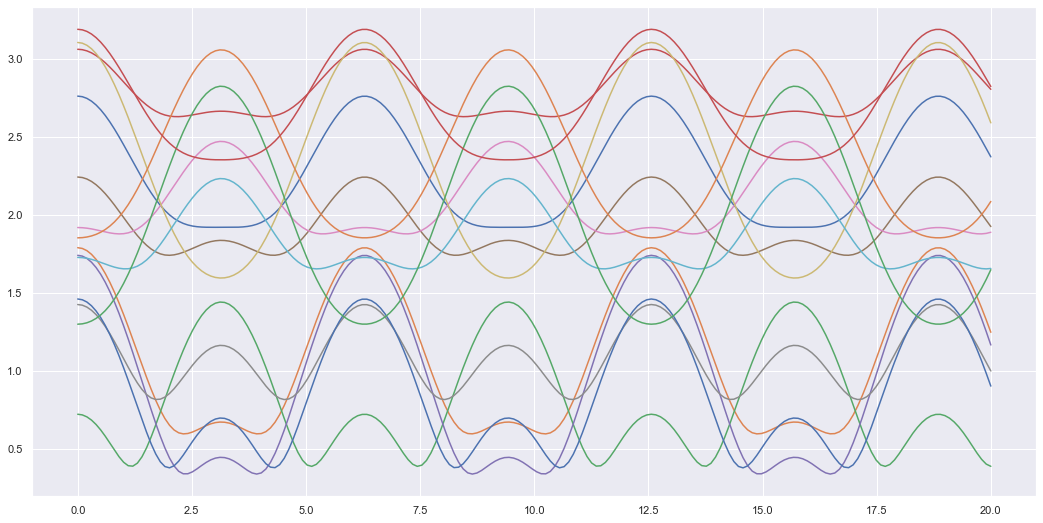

In [2]:
def sensor_loc(n):
    # coordinates of sensors in a cartesian plane (origin is when z=0 before spring-mass system is stretched)
    x_sen = np.random.normal(size=[n, 1]) 
    y_sen = np.random.normal(size=[n, 1])   
    z_sen = np.random.normal(size=[n, 1])   
    return (x_sen, y_sen, z_sen)

def get_sensor_values(sen_loc, t_min, t_max, res=100, m=1., k=1., z0=1.):
    t = np.linspace(t_min, t_max, res)
    z = z0*np.cos(np.sqrt(k/m) * t)     # spring mass motion along the z-axis 

    x_sen, y_sen, z_sen = sen_loc

    z_diff = z - z_sen  # only difference in the z-axis
    xs = np.sqrt(x_sen**2 + y_sen**2 + z_diff**2)

    return t, xs.T     # shape (time, n)

sensors = 14
sen_loc = sensor_loc(sensors)
t, X = get_sensor_values(sen_loc, 0, 20, res=200)

plt.figure(figsize=(18,9))
plt.plot(t, X)
plt.show()

To train a DVAE we will need a whole dataset of mass-spring system dynamics. Hence, I will simulate 100 different mass-spring systems with slightly different mass, spring constant and initial values for training and another 100 for testing the model. From now on I will refer to each different mass-spring system as a "unit" (as its easier to type). Hence, we have 100 different training units and 100 testing units. For model training, I have also used a sliding window so inputs into the model are "packets" of the signal with a time window size $T=40$. So inputs are tensors of size (batch size, T, sensors) while the testing inputs are still the entire time sequence. The training data is split into these time windowed packets, simply so we have more data that can be computed in parallel which allows for quicker training on a GPU. Each sensor signal is also normalised to have a mean of zero and a standard deviation of one. This helps with training the network as the signals don't have varying magnitudes, so the network can stick to a known range. 

In [3]:
def get_data(units, sensor_loc, t_min=0, t_max=20, res=200):
    data = [] 

    for _ in range(units):
        m = np.random.rand()
        k = np.random.rand()
        z0 = np.random.rand()

        t, X = get_sensor_values(sen_loc=sensor_loc, t_min=t_min, t_max=t_max, res=res, m=m, k=k, z0=z0)   # generate data for different spring-mass systems 

        # Normalize data to improve training 
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        data.append(torch.tensor(X))

    data = torch.stack(data, dim=0)     # shape (units, time, No. of sensors) 
    return data 

train_units = 100
test_units = 100 
train_data = get_data(train_units, sensor_loc=sen_loc)
test_data = get_data(test_units, sensor_loc=sen_loc)

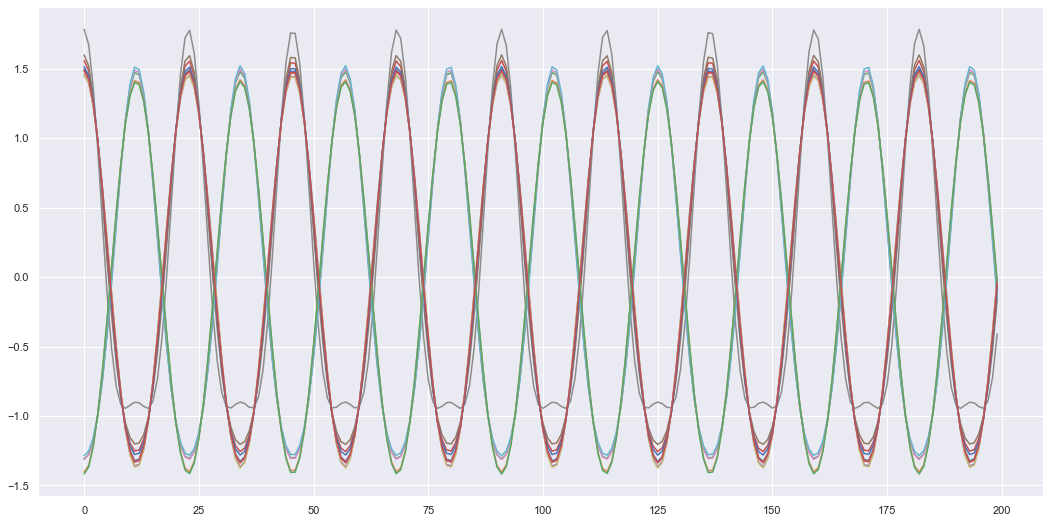

In [4]:
plt.figure(figsize=(18,9))
plt.plot(train_data[0])
plt.show()

In [5]:
def prep_data(data, T, bs):
    data = data.unfold(1, T, 1).permute(0,1,3,2)                    # (n, units, T, dim)
    data = torch.reshape(data, [-1,data.shape[-2],data.shape[-1]])  # (n*units, T, dim)

    train_DataSet = torch.utils.data.TensorDataset(data, data)
    train_loader = torch.utils.data.DataLoader(train_DataSet, shuffle=True, batch_size=bs)
    return train_loader 

T = 40
bs = 150 
train_loader = prep_data(train_data, 40, bs)

Here I simply have some code that defines some utilities like a simple Feedforward or Multilayer Perceptron (MLP) neural network as well as some loss functions needed in the DVAE i.e. the KL divergence between two Gaussian distributions and the log-likelihood of a Gaussian distribution. 

In [6]:
# -------------------
# Neural Network Utils
# -------------------
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, output_dim, bias=None)

    self.nonlinearity = torch.relu

  def forward(self, x):
    h = self.nonlinearity( self.linear1(x) )
    h = h + self.nonlinearity( self.linear2(h) )
    return self.linear3(h)

# --------------
# Loss 
# --------------
def loss_KLD(mean1, logvar1, mean2, logvar2):
    """
    KL-divergance between 2 Gaussian distributions, given the mean and log-variance of 
    Gaussian 1 and Gaussian 2. 
    """
    loss = -0.5 * torch.sum(logvar1 - logvar2
    - torch.div(logvar1.exp() + (mean1 - mean2) ** 2, logvar2.exp() + 1e-10))
    return loss 

def loglike(x, mean, lvar):
    var = torch.exp(lvar) 
    return -0.5 * torch.log(2*(np.pi)*var) - (x - mean) ** 2 / (2*var)

The following is code for the actual DVAE itself.

In [7]:
class DVAE(nn.Module):
    def __init__(self, xdim, zdim, hdim):
        super().__init__()
        self.xdim = xdim 
        self.zdim = zdim 
        self.hdim = hdim 

        # deterministic (RNNs)
        self.x_fwd = nn.GRU(xdim, hdim, batch_first=True)
        self.x_bck = nn.GRU(xdim+hdim, hdim, batch_first=True)

        # latent 
        self.z_gen = MLP(hdim+zdim, hdim*2, hdim) # prior
        self.z_inf = nn.GRU(hdim, zdim*2, batch_first=True) # inference model 

        self.prior_mean = MLP(hdim, hdim, zdim)
        self.prior_lvar = MLP(hdim, hdim, zdim)
        
        self.inf_mean = MLP(hdim, hdim, zdim)
        self.inf_lvar = MLP(hdim, hdim, zdim)

        # generative 
        self.x_dec = MLP(zdim+hdim, hdim, xdim*2)   # decoder

    # --- Helper functions --- 
    def sample(self, mean, lvar):
        std = torch.exp(0.5 * lvar)
        eps = torch.randn(mean.size()).to(mean.device)
        return mean + eps * std 

    def get_stats(self, stats):
        dim = stats.shape[-1] // 2 
        mean = stats[...,:dim]
        lvar = stats[...,dim:]
        return mean, lvar 

    ## --- Used for Training --- 
    def decode(self, hs, zs):
        hzs = torch.cat((hs, zs), dim=-1)
        x_stats = self.x_dec(hzs)

        x_mean, x_lvar = self.get_stats(x_stats)
        return x_mean, x_lvar 

    def represent_x(self, xs):
        bs, _, xdim = xs.shape

        x0 = torch.zeros(bs, 1, xdim).to(xs.device) # dummy init. var.
        x_tm1 = torch.cat((x0, xs[:,:-1,:]), 1) # tm1 = current time minus 1 = previous time variable 
        hs, _ = self.x_fwd(x_tm1)
        return hs

    def inference(self, xs):
        # --- Encode inputs to represent sequences x_{1:T} ---
        self.hs = self.represent_x(xs)

        h_x = torch.cat((self.hs, xs), dim=-1)
        g_revs, _ = self.x_bck(torch.flip(h_x, [1]))    # backward RNN 
        gs = torch.flip(g_revs, [1]) 

        # --- Latent ---
        z_stats, _ = self.z_inf(gs)
        z_means, z_lvars = self.get_stats(z_stats)
        zs = self.sample(z_means, z_lvars)
        
        return zs, z_means, z_lvars

    def generate_z(self, hs, z_tm1):
        hzs = torch.cat((hs, z_tm1), dim=-1)
        hzs = self.z_gen(hzs)

        z_means = self.prior_mean(hzs)
        z_lvars = self.prior_lvar(hzs)
        return z_means, z_lvars

    def generate_x(self, zs, use_pred=1):
        bs, seq, _ = zs.shape

        x_tm1 = torch.zeros(bs, 1, self.xdim).to(zs.device)    # dummy init. var. 
        h_tm1 = torch.zeros(1, bs, self.hdim).to(zs.device)

        x_means = []
        x_lvars = [] 
        hs = []

        for t in range(seq):
            h, h_tm1 = self.x_fwd(x_tm1, h_tm1)   # h.size = (bs, 1, hdim), h_tm1.size = (1, bs, hdim)

            # during training randomly replace x_{1:t} estimates with ground truth
            random_num = np.random.uniform()
            if random_num <= use_pred:
                h = h # use prediction
            else:
                h = self.hs[:,t,:].unsqueeze(1) # use ground truth

            # estimate x 
            x_mean, x_lvar = self.decode(h, zs[:,t,:].unsqueeze(1))   # size (bs, 1, xdim)
            x_tm1 = self.sample(x_mean, x_lvar)

            x_means.append(x_mean)
            x_lvars.append(x_lvar)
            hs.append(h)
        
        x_means = torch.cat(x_means, dim=1)
        x_lvars = torch.cat(x_lvars, dim=1)
        hs = torch.cat(hs, dim=1)

        return x_means, x_lvars, hs 

    def forward(self, xs, use_pred=1):
        bs = xs.shape[0]

        # generate latent sequence from training data using the inference model 
        zs_inf, zs_inf_mean, zs_inf_lvar = self.inference(xs)

        # use latent sequence from inference model to estimate x-values 
        x_mean, x_lvar, hs = self.generate_x(zs_inf, use_pred=use_pred)

        # generate prior z-values 
        z0 = torch.zeros(bs, 1, self.zdim).to(xs.device)
        z_tm1 = torch.cat((z0, zs_inf[:,:-1,:]), dim=1)
        zs_gen_mean, zs_gen_lvar = self.generate_z(hs, z_tm1)

        # KL-div between inference and prior z-values 
        kl = loss_KLD(zs_gen_mean, zs_gen_lvar, zs_inf_mean, zs_inf_lvar) / bs 

        return kl, x_mean, x_lvar 

    def get_loss(self, xs, use_pred=1):
        kl, x_mean, x_lvar = self.forward(xs, use_pred=use_pred)
        nll = -loglike(xs, x_mean, x_lvar).mean()
        return kl, nll
    
    ## --- Used for Testing ---
    def generate(self, xs, return_hidden=False):
        '''
        Used to test reconstructions of xs given xs itself 
        '''
        bs, seq, xdim = xs.shape

        # --- Encode inputs to represent sequences x_{1:T} ---
        x0 = torch.zeros([bs, 1, xdim]).to(xs.device)
        x_tm1 = torch.cat((x0, xs[:,:-1,:]), dim=-2)  # x_{t-1} outputs h_t
        hs, _ = self.x_fwd(x_tm1)     # forward RNN outputs h_{1:T} given x_{0:T-1}

        # --- Storage --- 
        z_means = [] 
        z_lvars = [] 
        zs = [] 
        
        # --- Latent ---
        z_tm1 = torch.zeros(bs, self.zdim).to(xs.device)
        for t in range(seq):
            hzs = torch.cat((hs[:,t,:], z_tm1), dim=-1) # (bs, hdim+zdim)
            hzs = self.z_gen(hzs)

            z_mean = self.prior_mean(hzs)
            z_lvar = self.prior_lvar(hzs)
            z = self.sample(z_mean, z_lvar)

            z_means.append(z_mean)
            z_lvars.append(z_lvar)
            zs.append(z)

        z_means = torch.stack(z_means, dim=1)
        z_lvars = torch.stack(z_lvars, dim=1)
        zs = torch.stack(zs, dim=1)

        # --- Generate/Decode --- 
        x_mean, x_lvar = self.decode(hs, zs)

        if return_hidden:
            return x_mean, x_lvar, z_means, z_lvars, hs

        return x_mean, x_lvar, z_means, z_lvars

    def generate_rec(self, x0, h0, z0_mean, z0_lvar):
        '''
        generates given time = t-1 values generate values at time = t 
        '''
        # generate values reccurently i.e. given values @ t-1 generates values @ t 
        h1, h = self.x_fwd(x0, h0)
        z0 = self.sample(z0_mean, z0_lvar)
        hz = torch.cat((h1, z0), dim=-1)

        hz = self.z_gen(hz)
        z_mean = self.prior_mean(hz)
        z_lvar = self.prior_lvar(hz)
        z1 = self.sample(z_mean, z_lvar)

        x_mean, x_lvar = self.decode(h1, z1)

        return x_mean, x_lvar, z_mean, z_lvar, h

    def overshoot(self, xs, split=None):
        """
        Performs sequential overshooting. 
        i.e. randomly chooses a cut-off point in the data sequence xs and splits 
        it into a known and unknown sequence. Then uses the known sequence to extrapolate
        the rest of the unknown sequence and compares with the true result. 
        
        e.g. 
        xs = [x1, x2, x3, x4, x5, x6]
        known_xs = [x1, x2]
        unknown_xs = [x3, x4, x5, x6]

        generate_known_xs = [x1_gen, x2_gen]

        using x2_gen as the initial condition 
        extrapolated_xs = [x3_gen, x4_gen, x5_gen, x6_gen]

        xs_gen = [x1_gen, x2_gen, x3_gen, x4_gen, x5_gen, x6_gen]

        overshoot_loss = loglike(xs, xs_gen_mean, xs_gen_lvar)
        """
        seq = xs.shape[1]
        if split == None:
            percent = np.random.uniform(0.1)
            known_seq = int(seq * percent)
        else:
            known_seq = int(seq * split)
        T = seq - known_seq    # extrapolation length 

        # storing 
        xs_means = []
        xs_lvars = [] 
        zs_means = [] 
        zs_lvars = [] 
        def store(x_mean, x_lvar, z_mean, z_lvar):
            xs_means.append(x_mean)
            xs_lvars.append(x_lvar)
            zs_means.append(z_mean)
            zs_lvars.append(z_lvar)
            return xs_means, xs_lvars, zs_means, zs_lvars
        
        # generating and extrapolating values 
        obs = xs[:,:known_seq,:]
        x_mean, x_lvar, z_mean, z_lvar, hs = self.generate(obs, return_hidden=True)
        xs_means, xs_lvars, zs_means, zs_lvars = store(x_mean, x_lvar, z_mean, z_lvar)

        x = self.sample(x_mean, x_lvar)
        x = x[:,-1:,:]
        h = hs[:,-1,:].unsqueeze(0) 
        z_mean = z_mean[:,-1:,:]
        z_lvar = z_lvar[:,-1:,:]
        for t in range(T):
            x_mean, x_lvar, z_mean, z_lvar, h = self.generate_rec(x, h, z_mean, z_lvar)
            xs_means, xs_lvars, zs_means, zs_lvars = store(x_mean, x_lvar, z_mean, z_lvar)

            x = self.sample(x_mean, x_lvar)

        xs_means = torch.cat(xs_means, dim=1)
        xs_lvars = torch.cat(xs_lvars, dim=1)
        zs_means = torch.cat(zs_means, dim=1)
        zs_lvars = torch.cat(zs_lvars, dim=1)

        return xs_means, xs_lvars, zs_means, zs_lvars



Now that we have defined all the components we can train the model.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xdim = sensors 
hdim = 50 
zdim = 1

model = DVAE(xdim, zdim, hdim).to(device)

lr = 1e-3 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
def train_model(model, optimizer, train_loader, epochs, use_pred=1):
    for epoch in range(1, epochs+1):
        for xs, _ in train_loader:
            xs = xs.float().to(device)

            kl, nll = model.get_loss(xs, use_pred)

            elbo = nll + kl

            elbo.backward()
            optimizer.step()
            optimizer.zero_grad() 

        if epoch == 1 or (epoch % 10) == 0: 
            print("Epoch: {}/{}, elbo: {:.4f}, nll: {:.4f}, kl: {:.4f}"
            .format(epoch, epochs, elbo, nll, kl))

In [10]:
train_model(model, optimizer, train_loader, epochs=100, use_pred=0.5)

Epoch: 1/100, elbo: 20.8290, nll: 0.8044, kl: 20.0246
Epoch: 10/100, elbo: 20.5449, nll: 0.5424, kl: 20.0025
Epoch: 20/100, elbo: 19.2262, nll: -0.7744, kl: 20.0007
Epoch: 30/100, elbo: 20.4248, nll: 0.4242, kl: 20.0005
Epoch: 40/100, elbo: 19.9360, nll: -0.0643, kl: 20.0003
Epoch: 50/100, elbo: 19.3641, nll: -0.6360, kl: 20.0002
Epoch: 60/100, elbo: 18.6368, nll: -1.3633, kl: 20.0001
Epoch: 70/100, elbo: 18.8004, nll: -1.2230, kl: 20.0234
Epoch: 80/100, elbo: 19.8288, nll: -0.1713, kl: 20.0001
Epoch: 90/100, elbo: 18.4936, nll: -1.5064, kl: 20.0000
Epoch: 100/100, elbo: 18.1595, nll: -1.8405, kl: 20.0000


Here we will test the DVAE by first seeing if the generative model can simply reconstruct the sensor signals given. Essentially we will give it the true $x_{t-1}$ value and it will generate $z_t$, which will be decoded to $x_t$. This will be done for all $t \in [0,T]$ where $T$ is the entire sequence (instead of just a time window like in training). Since $x_0$ is the estimated I will ignore it when plotting as the DVAE did not generate this value. 

In [11]:
def test_model(model, test_data):
    results = {
        "x_true": [], 
        "x_mean": [],
        "x_stds": [],
        "z_mean": [],
        "z_stds": [], 
        "rmse": [],
    }

    for xs in test_data:
        xs = xs.unsqueeze(0).float().to(device)
        
        x_mean, x_lvar, z_mean, z_lvar = model.generate(xs)
        
        RMSE = ((x_mean - xs) ** 2).mean()
        x_stds = torch.exp(0.5 * x_lvar)
        z_stds = torch.exp(0.5 * z_lvar)
        
        results["x_true"].append(xs.detach().cpu().numpy())
        results["x_mean"].append(x_mean.detach().cpu().numpy())
        results["x_stds"].append(x_stds.detach().cpu().numpy())
        results["z_mean"].append(z_mean.detach().cpu().numpy())
        results["z_stds"].append(z_stds.detach().cpu().numpy())
        results["rmse"].append(RMSE.detach().cpu().numpy())

    return results 

In [12]:
results = test_model(model, test_data)
print("AVG RMSE: ", sum(results["rmse"]) / len(results["rmse"]))

AVG RMSE:  0.039877471905201675


I only plot one sensor below otherwise I find it gets to cluttered and difficult to see how well it performed. 

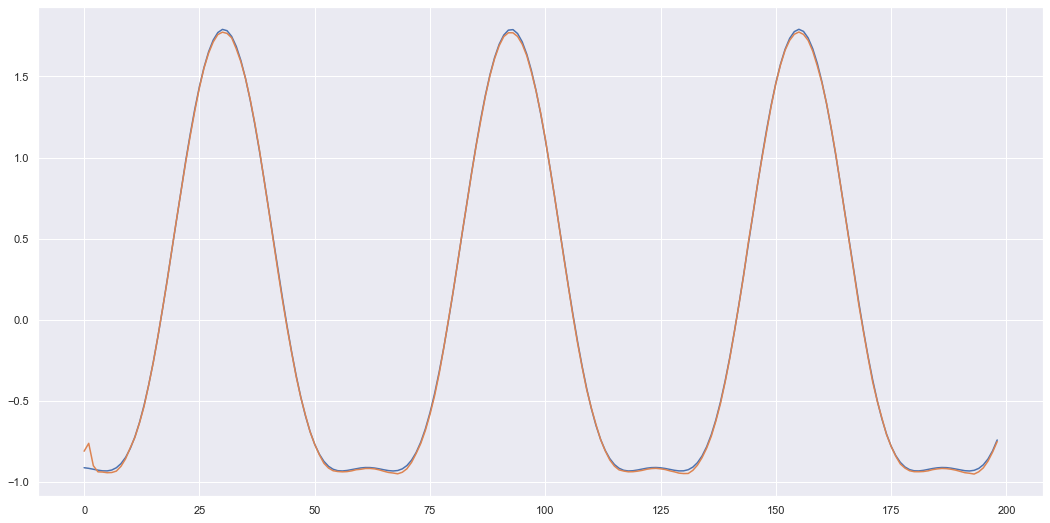

In [70]:
unit = 11 
# since x0 = tensor of zeros the first value can be quite off, but once real data comes in we can see it tracks the signal nicely 
x_true = results["x_true"][unit-1][0,1:,:]
x_mean = results["x_mean"][unit-1][0,1:,:]
z_mean = results["z_mean"][unit-1][0,1:,:]
z_stds = results["z_stds"][unit-1][0,1:,:]

s = 10   # sensor number 
plt.figure(figsize=(18,9))
plt.plot(x_true[...,s-1])
plt.plot(x_mean[...,s-1])
plt.show()

We can also plot the latent variable sequences we generated when we reconstructed all these sensors. 

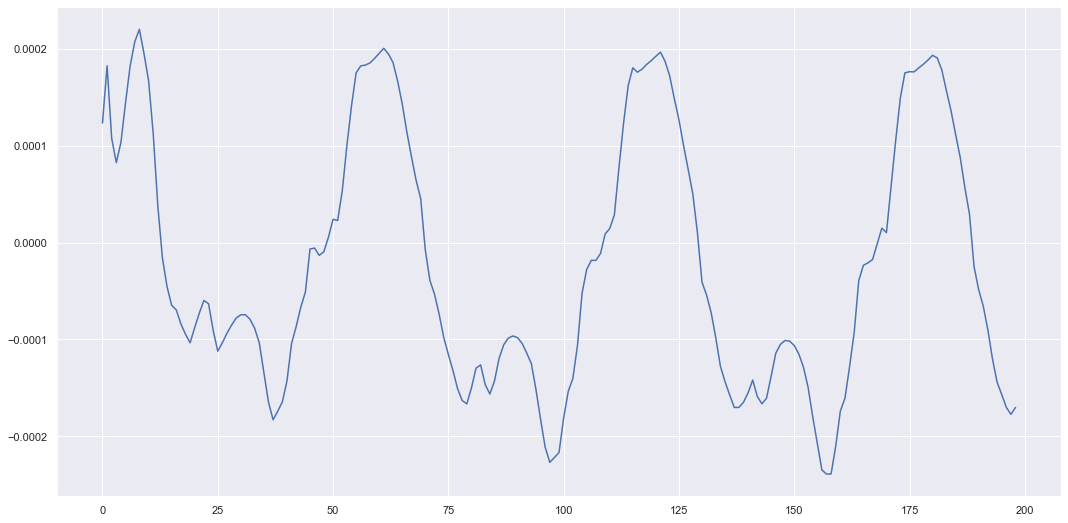

In [14]:
plt.figure(figsize=(18,9))
plt.plot(z_mean)
plt.show()

Plotting all the latent variable sequences we get. 

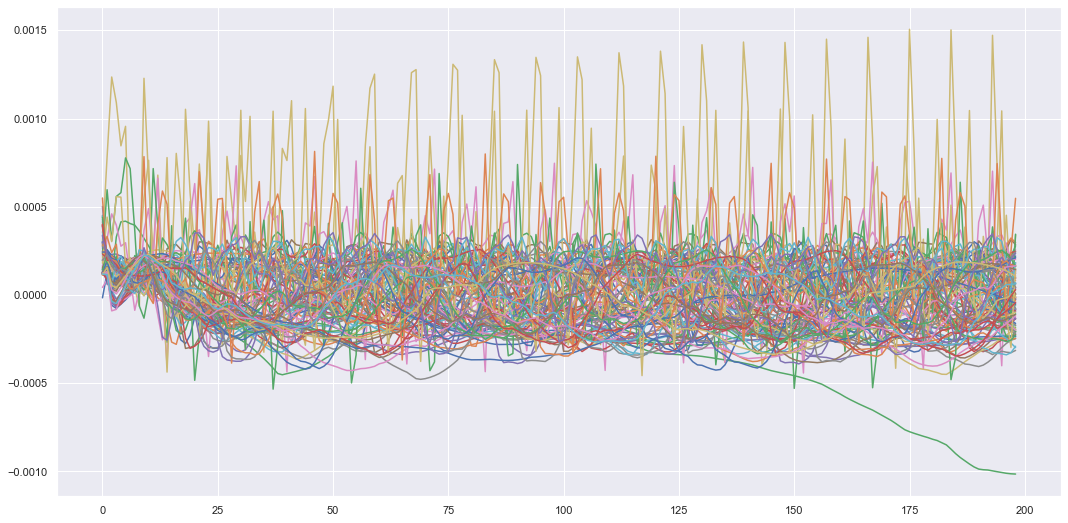

In [16]:
#collapse-hide
plt.figure(figsize=(18,9))
for i in range(100):
    plt.plot(results["z_mean"][i][0,1:,:])
plt.show()

You could imagine we could interpolate a new latent sequence in this latent space using our own initial condition and the prior latent dynamics. If we did this and decoded it back to the input space we should get new reconstructed sensor values of some fictitious mass-spring system that doesn't exist (I'm aware none of these systems existed as I simulated them, but if this was all done through real life experiments I could simulate a new realistic looking virtual experiment). This could be applied in interesting applications such as generating audio, where we use real audio signals to train the model and then generate new audio using the trained model. We can also use a conditional DVAE where we generate new inputs conditioned on other variables. This can be used in machinery prognostics where you might want to find the Remaining Useful Life (RUL) of a machine or component. The RUL could be the generated inputs and these can be conditioned on sensor values. This would change the DVAE model to, 

$$
    \text{Encoder/Inference: } q_{\phi}(z_t|z_{1:t-1}, x_{1:T}, u_{1:T}) \\
    \text{Decoder: } p_{\theta_x}(x_t|x_{1:t-1}, z_{1:t}, u_{1:t}) \\
    \text{Prior: } p_{\theta_z}(z_t|z_{1:t-1}, x_{1:t-1}, u_{1:t})
$$

where in this example $x_t = (RUL)_t$ and $u_t = $ sensor signals at time $t$. 

The code below shows how one would generate new signals from "virtual" mass-spring systems that were not seen during training. 

In [71]:
def generate_sensors(model, xs, split, device):
    results = {
        "x_mean": [], 
        "x_stds": [],
        "z_mean": [],
        "z_stds": []
    }    
    xs = xs.unsqueeze(0).float().to(device)
    def add_to_results(results, x_mean, x_lvar, z_mean, z_lvar):
        x_stds = torch.exp(0.5 * x_lvar)
        z_stds = torch.exp(0.5 * z_lvar)

        results["x_mean"].append(x_mean.detach().cpu())
        results["x_stds"].append(x_stds.detach().cpu())
        results["z_mean"].append(z_mean.detach().cpu())
        results["z_stds"].append(z_stds.detach().cpu())
        return results 

    x_mean, x_lvar, z_mean, z_lvar = model.overshoot(xs, split)
    results = add_to_results(results, x_mean, x_lvar, z_mean, z_lvar)

    results["x_mean"] = torch.cat(results["x_mean"], dim=1).numpy()
    results["x_stds"] = torch.cat(results["x_stds"], dim=1).numpy()
    results["z_mean"] = torch.cat(results["z_mean"], dim=1).numpy()
    results["z_stds"] = torch.cat(results["z_stds"], dim=1).numpy()

    return results 

unit = 10
split = 0.7
seq = test_data[unit-1].shape[0]

gen_results = generate_sensors(model, test_data[unit-1], split, device=device)

Here we give our model 70% of the sensors and ask it to extrapolate the 30% we didn't give it. We can plot the results below.

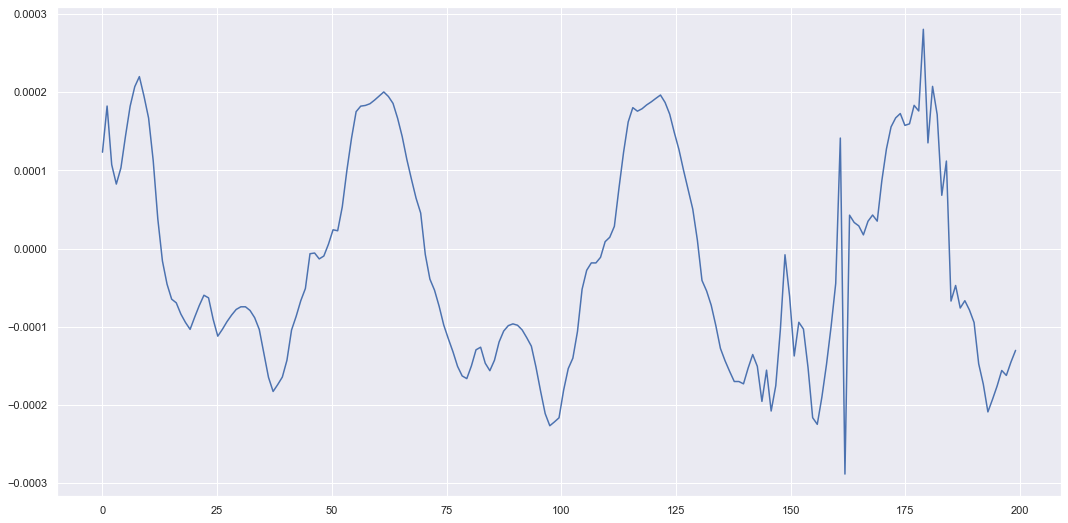

In [81]:
z_mean = gen_results["z_mean"][0,1:,0]
t = torch.linspace(0, z_mean.shape[0], z_mean.shape[0])

plt.figure(figsize=(18,9))
plt.plot(t, z_mean)
plt.show()

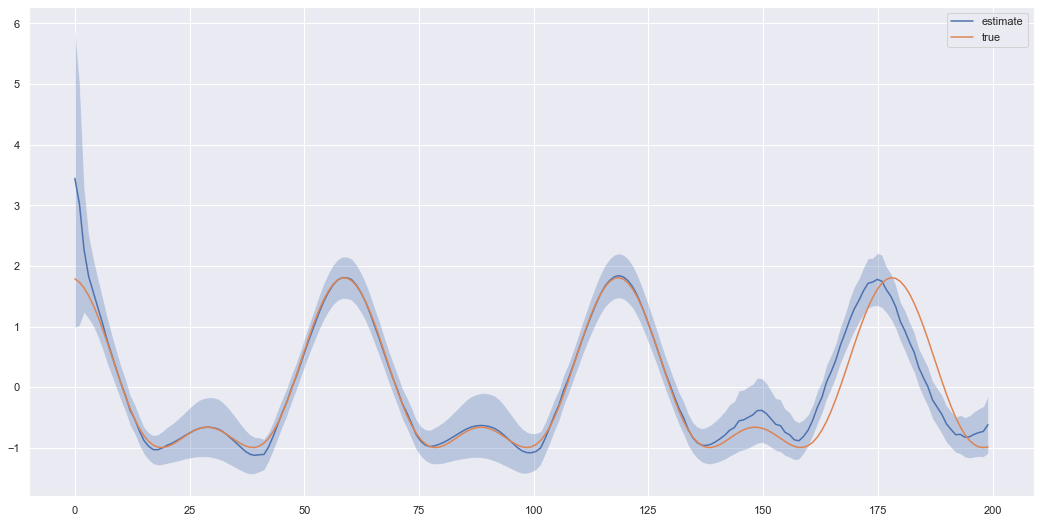

In [80]:
s = 7 # sensor number 
x_mean = gen_results["x_mean"][0,1:,s]
x_stds = gen_results["x_stds"][0,1:,s]

plt.figure(figsize=(18,9))
plt.plot(t, x_mean, label="estimate")
plt.plot(t, test_data[unit-1][1:,s], label="true")
plt.fill_between(t, x_mean + 3*x_stds, x_mean - 3*x_stds, alpha=0.3)
plt.legend()
plt.show()

This doesn't look too bad, but each time we are sampling a different $z_t$ value at each time and decoding it. Hence, each time we call the function to extrapolate we generate a different trajectory $z_{1:T}$ and decode to $x_{1:T}$. So lets run the same code again and get an idea of how much the extrapolated results can vary. 

In [39]:
unit = 10
split = 0.7
seq = test_data[unit-1].shape[0]

gen_results = generate_sensors(model, test_data[unit-1], split, device=device)

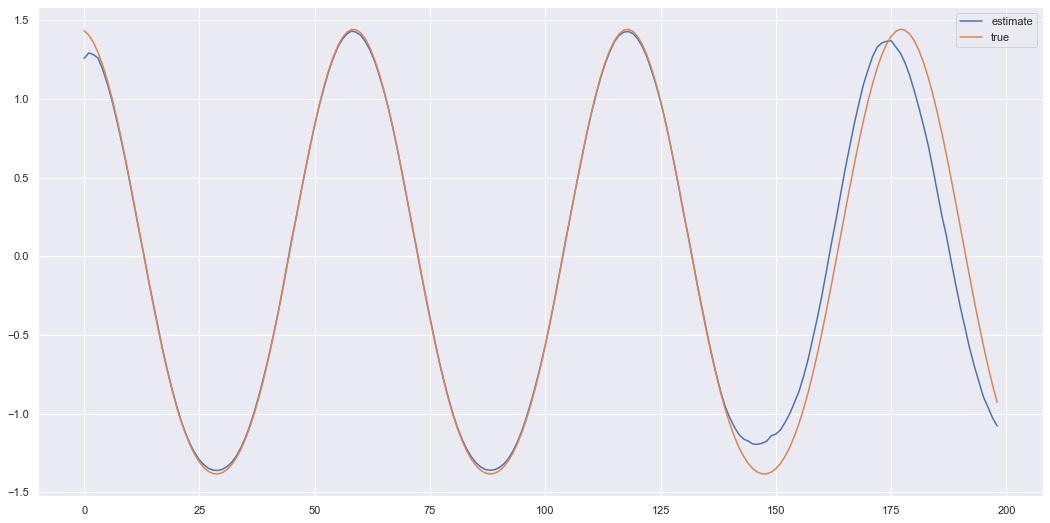

In [40]:
s = 1

plt.figure(figsize=(18,9))
plt.plot(gen_results["x_mean"][0,1:,s], label="estimate")
plt.plot(test_data[unit-1][1:,s], label="true")
plt.legend()
plt.show()

As you can see the trajectory still maintains the oscillating dynamics but can have a lot of variation when extrapolating. But we can generate signals which look somewhat like the original signal in the sense certain characteristics (such as the oscillations) are captured by the underlying prior latent dynamics. The latent dynamics could be smoother if we played around with the prior model. Here we just used a standard feedforward network which took $z_{t-1}$ to $z_{t}$. To improve the results perhaps a better prior model could be used with more structured dynamics. But hopefully the theory and the simple example (relatively speaking) helps you if you want to use these for an application. So we at least finish this post with an idea of how to improve the model and a cool way of generating dynamic data. 

I think this is a good place to stop. Ultimately the aim of these posts is to build up to the point where we are using DVAEs to estimate the RUL of machinery based on input sensor signals. So the theory and basic examples shown here is to get everyone comfortable with the basic ideas behind DVAEs before we move on to more practical applications. Hopefully this post has aided your understanding of DVAEs (and/or introduced you to a cool new technique), I know the mass-spring system analogy really helped me think about how DVAEs are VAEs but extended to deal with dynamic systems or sequential data. 